In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)[:1] # select the top 50 symbols
len(subset_symbols),subset_symbols[0]

(1, 'BTC')

In [3]:
top50symbols_usdt = [s+"USDT" for s in subset_symbols[:1]]

In [4]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(3000)):
    with open(f"2_3_1_analysisdata/2_3_1_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list2 = pickle.load(f)
    dfmpl_list = [ d for d in dfmpl_list2 if d[1] in top50symbols_usdt]
    dfmpl_list_list.append( dfmpl_list.copy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:46<00:00, 64.02it/s]


In [5]:
%%time
for symm in tqdm.tqdm(subset_symbols):
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    if not all(np.diff(df__.index,2).astype(float)==0):
        print(symm)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]

BTCUSDT
CPU times: total: 391 ms
Wall time: 665 ms


# concat the dfs, store into a list of dfs, also store a list of corresponding symbols

In [6]:
dfmpl_list = []

for idd,symm in enumerate(tqdm.tqdm(subset_symbols)):
    #if idd<110:continue
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    dfmpl_list.append( (df__.copy(),symm,idd) ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


In [7]:
dfmpl,symm,idd = dfmpl_list[0]
dfmpl,symm,idd,len(dfmpl_list)

(                         Open      High       Low     Close     Volume
 Date                                                                  
 2018-05-02 05:34:00   9098.00   9098.97   9091.21   9095.04  28.507367
 2018-05-02 05:35:00   9095.04   9098.99   9095.01   9098.95   9.907257
 2018-05-02 05:36:00   9098.95   9099.95   9095.01   9097.98  16.264413
 2018-05-02 05:37:00   9097.98   9097.98   9080.00   9080.00  27.338032
 2018-05-02 05:38:00   9080.00   9091.20   9075.19   9089.85  16.275807
 ...                       ...       ...       ...       ...        ...
 2024-01-14 13:29:00  42737.46  42740.00  42724.00  42739.99   7.939610
 2024-01-14 13:30:00  42740.00  42746.00  42739.99  42746.00   6.908090
 2024-01-14 13:31:00  42745.99  42746.00  42732.24  42732.24   6.752950
 2024-01-14 13:32:00  42732.25  42737.25  42732.24  42737.24   5.123370
 2024-01-14 13:33:00  42737.25  42737.25  42735.20  42735.21   5.441170
 
 [2994097 rows x 5 columns],
 'BTCUSDT',
 0,
 1)

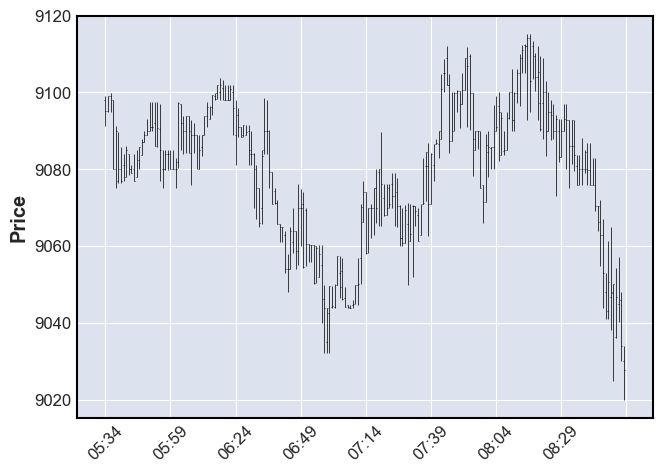

In [8]:
mpf.plot(dfmpl.iloc[:200])

In [9]:
import pandas_ta as ta
import talib
from talib import MA_Type

In [10]:
def find_ones_with_min_distance(data, min_distance=1):
    ones_positions = []
    last_one = -min_distance - 1

    for i, value in enumerate(data):
        if value == 1:
            if i - last_one >= min_distance:
                ones_positions.append(i)
                last_one = i

    return ones_positions
 


In [11]:
%%time
upper30, middle30, lower30 = talib.BBANDS(dfmpl.Close,timeperiod=30, matype=MA_Type.T3)
upper15, middle15, lower15 = talib.BBANDS(dfmpl.Close,timeperiod=15, matype=MA_Type.T3)
#upper, middle, lower = talib.BBANDS(dfmpl.Close,timeperiod=5, nbdevup=2, nbdevdn=2, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl.Close,timeperiod=50)
change = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).rolling(4).mean()
momentum = talib.MOM(dfmpl.Close,timeperiod=40)
momentum_rolling30 = momentum.rolling(30).mean()
momentum_rolling40 = momentum.rolling(40).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl.Close,timeperiod=30,fastk_period=25,fastd_period=15)

CPU times: total: 547 ms
Wall time: 824 ms


In [12]:
%%time
vals = np.clip((np.clip((dfmpl.Close-middle30)/(upper30-lower30),-5,5)+2)/4,0,1)
vals = vals.values
vals = vals[np.isfinite(vals)]

CPU times: total: 156 ms
Wall time: 212 ms


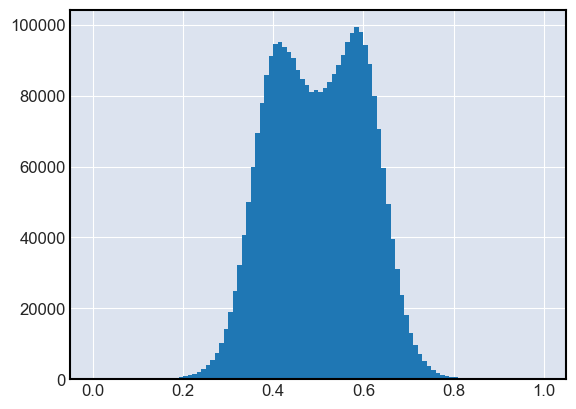

In [13]:
plt.hist(vals,bins=100); 

In [14]:
import torch

In [15]:
mfi = talib.MFI(dfmpl.High,dfmpl.Low,dfmpl.Close,dfmpl.Volume,20)

In [16]:
%%time
binary_condition = (momentum<-450) #& (momentum_rolling30<-250) & (momentum_rolling30.shift(30)<50) & ( momentum_rolling30 <momentum_rolling40)
potential_candidates = np.where(binary_condition)[0]
#potential_candidates = np.where(change<-0.002)[0]
#potential_candidates

CPU times: total: 0 ns
Wall time: 8.98 ms


In [17]:
potential_candidates = find_ones_with_min_distance(binary_condition,40)

In [18]:
momentum[2718008]

-475.52000000000044

In [19]:
dd_ = (dfmpl.iloc[-1].name-dfmpl.iloc[0].name).total_seconds()/3600/24
f"{dd_/len(potential_candidates):.4f} days per trade, {len(potential_candidates)} trades in {dd_:.0f} days"

'0.6873 days per trade, 3031 trades in 2083 days'

In [20]:
len(potential_candidates),len(potential_candidates[::27])

(3031, 113)

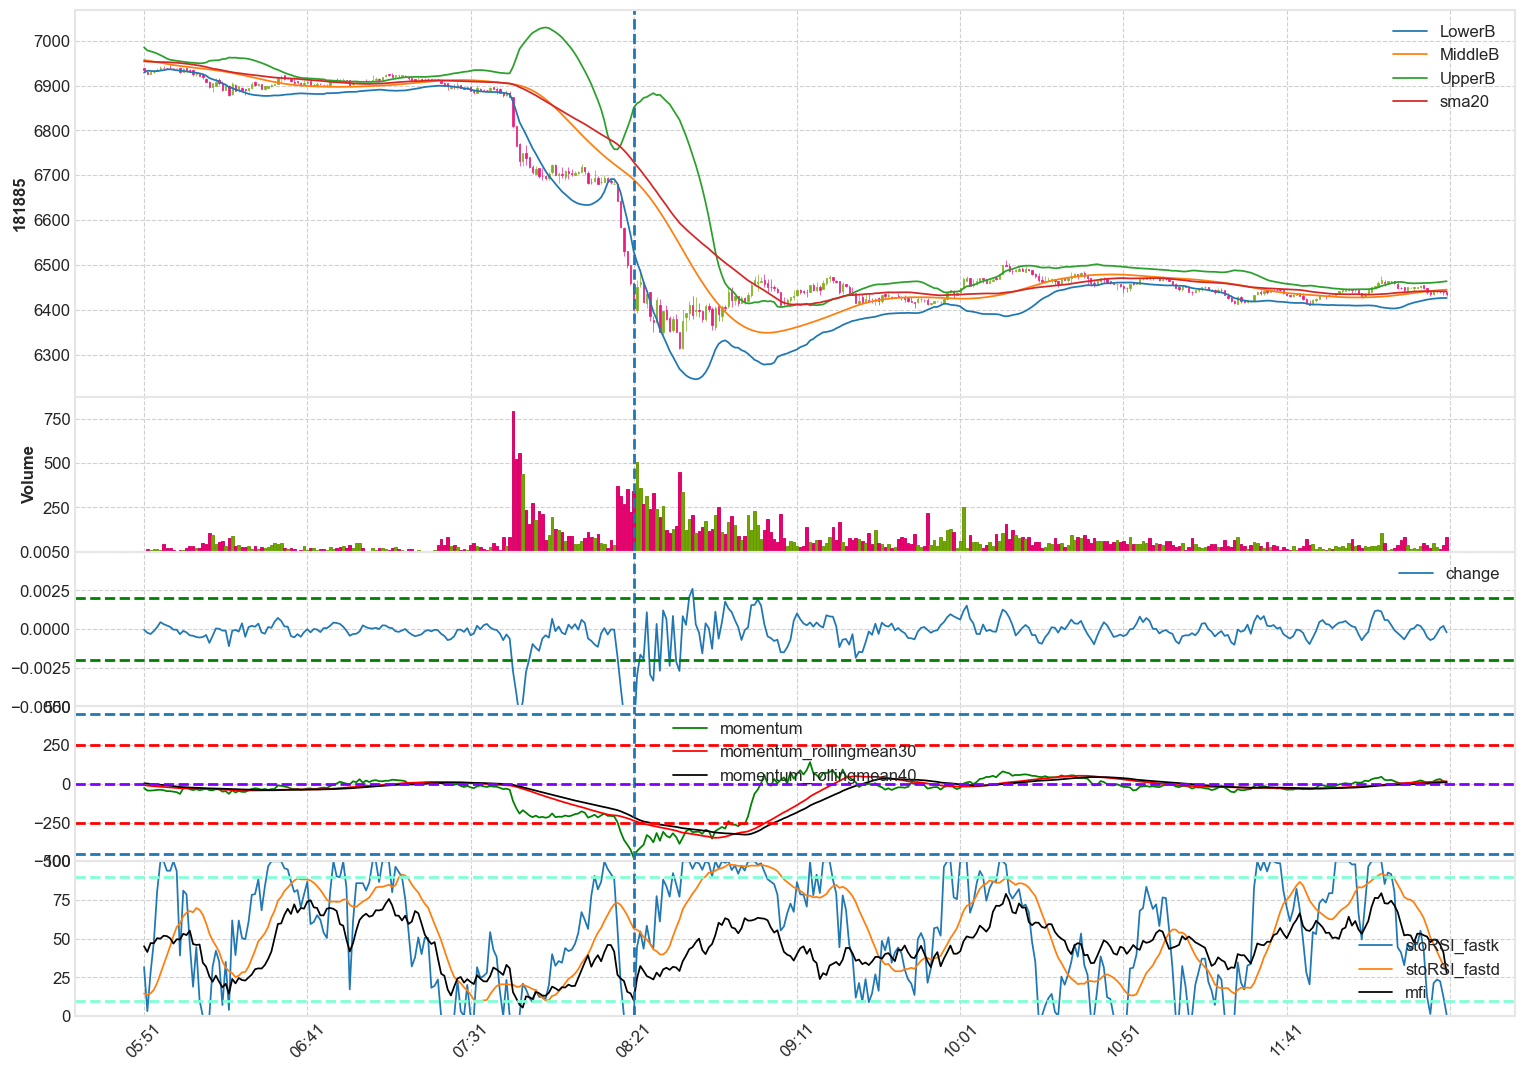

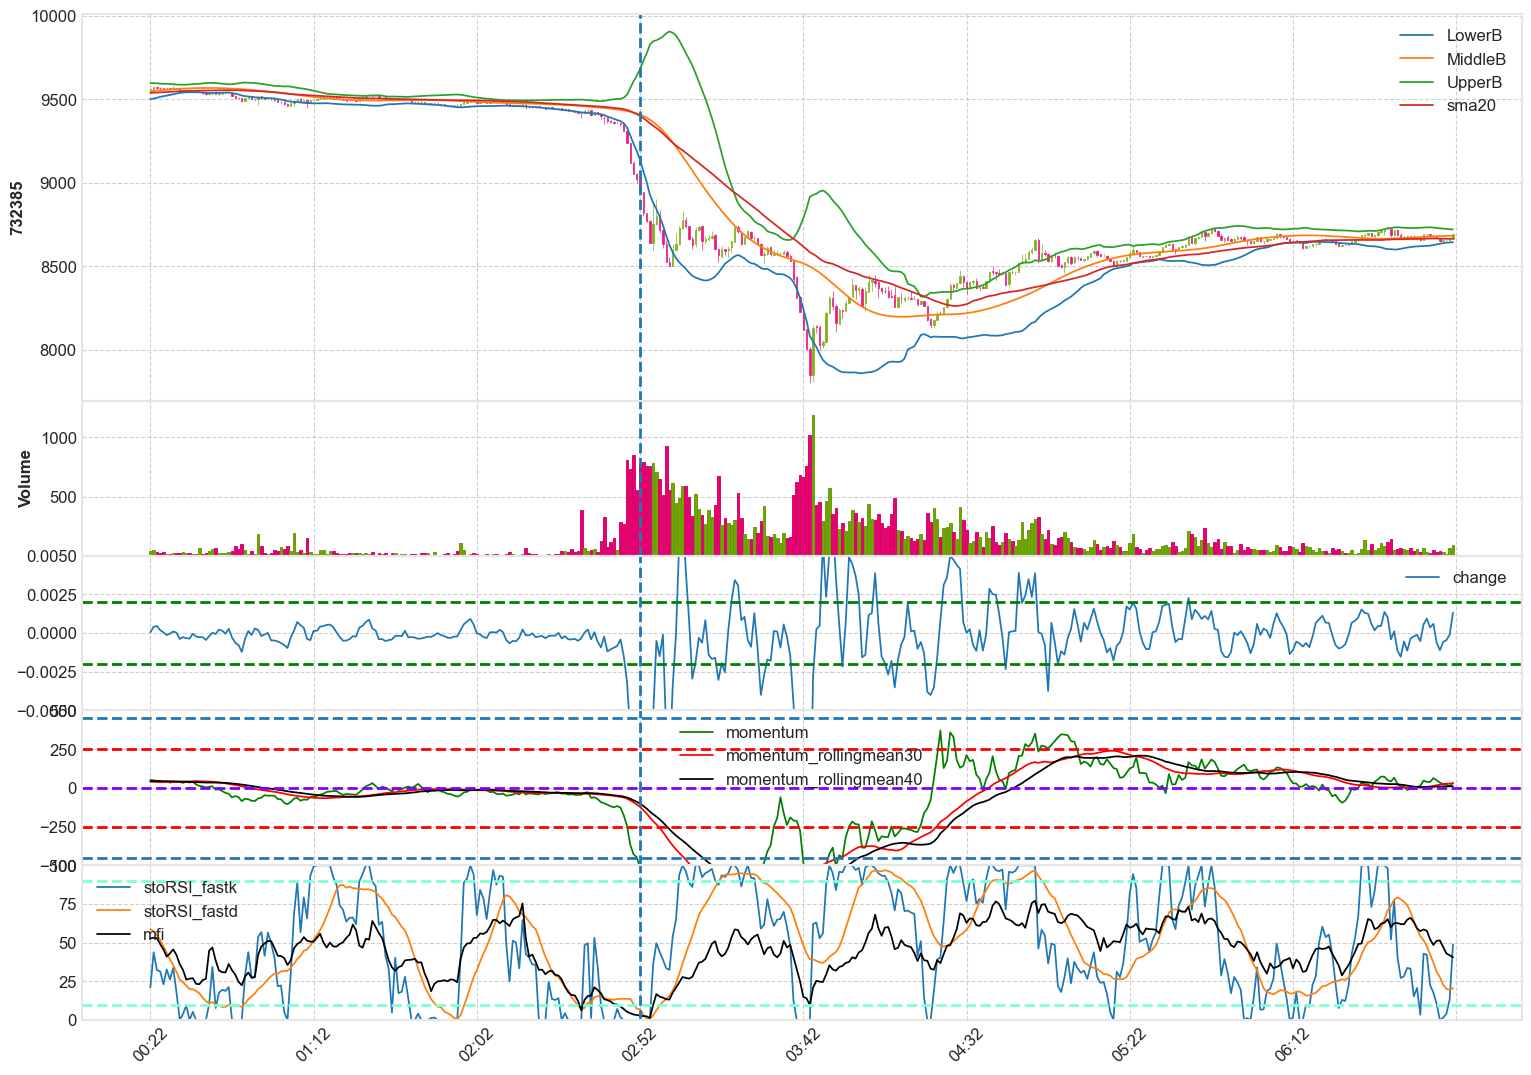

CPU times: total: 2.92 s
Wall time: 3.89 s


In [21]:
%%time
for inddex_of_frame in potential_candidates[:31:27]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    my_vlines=[dfmpl.iloc[inddex_of_frame].name]
    my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower30.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle30.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper30.iloc[lowerlim:upperlim],label="UpperB"),
              mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
              mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
              mpf.make_addplot(momentum.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
              mpf.make_addplot(momentum_rolling30.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean30",color="r",secondary_y=False),
              mpf.make_addplot(momentum_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean40",color="k",secondary_y=False),
              mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd"),
              mpf.make_addplot(mfi.iloc[lowerlim:upperlim],panel=4,label="mfi",color="k") 
             ]
    fig, axlist = mpf.plot(dfmpl.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2.5,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for axi,ax in enumerate(axlist):
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--')
        if axi==4:
            ax.axhline(-0.002, linestyle='--',c="g")
            ax.axhline(0.002, linestyle='--',c="g")
            ax.set_ylim(-0.005,0.005)
        if axi==6:
            ax.axhline(-450, linestyle='--')
            ax.axhline(450, linestyle='--')
            ax.axhline(-250, linestyle='--',c="r")
            ax.axhline(250, linestyle='--',c="r")
            ax.axhline(0,linestyle="--",c="#7F00FF",)
            ax.set_ylim(-500,500)
        if axi==8:
            ax.axhline(90, linestyle='--',c="#7FFFD4")
            ax.axhline(10, linestyle='--',c="#7FFFD4")
            ax.set_ylim(0,100)
    mpf.show()

# extracting features for CNN

In [22]:
%%time
upper30, middle30, lower30 = talib.BBANDS(dfmpl.Close,timeperiod=30, matype=MA_Type.T3)
upper15, middle15, lower15 = talib.BBANDS(dfmpl.Close,timeperiod=15, matype=MA_Type.T3)
#upper, middle, lower = talib.BBANDS(dfmpl.Close,timeperiod=5, nbdevup=2, nbdevdn=2, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl.Close,timeperiod=50)
change = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).rolling(4).mean()
momentum = talib.MOM(dfmpl.Close,timeperiod=40)
momentum_rolling30 = momentum.rolling(30).mean()
momentum_rolling40 = momentum.rolling(40).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl.Close,timeperiod=30,fastk_period=25,fastd_period=15)

CPU times: total: 625 ms
Wall time: 816 ms


In [23]:
%%time
bbp30 = np.clip((np.clip((dfmpl.Close-middle30)/(upper30-lower30),-5,5)+2)/4,0,1)
bbp15 = np.clip((np.clip((dfmpl.Close-middle15)/(upper15-lower15),-5,5)+2)/4,0,1)
stoRSI_fastk_norm = np.clip(stoRSI_fastk/100,0,1)
stoRSI_fastd_norm = np.clip(stoRSI_fastd/100,0,1)

CPU times: total: 422 ms
Wall time: 539 ms


In [24]:
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl.Close,timeperiod=30,fastk_period=25,fastd_period=15)

In [25]:
stoRSI_fastk2,stoRSI_fastd2 = talib.STOCHRSI(dfmpl.Close[500:],timeperiod=30,fastk_period=25,fastd_period=15)

In [26]:
lower_lim = 370
upper_lim=390
for x_,y_ in zip(stoRSI_fastk2.iloc[lower_lim:upper_lim] ,stoRSI_fastk.iloc[500+lower_lim:500+upper_lim]):
    print(f"{x_:.6f},  {y_:.6f}, diff {x_-y_:.6f}")

0.000000,  0.000000, diff 0.000000
25.575056,  25.575089, diff -0.000034
4.069258,  4.069269, diff -0.000011
3.835254,  3.835265, diff -0.000011
17.101425,  17.101455, diff -0.000030
28.004258,  28.004306, diff -0.000047
0.000000,  0.000000, diff 0.000000
27.013456,  27.013504, diff -0.000048
29.145486,  29.145537, diff -0.000051
10.831513,  10.831536, diff -0.000024
1.795870,  1.795879, diff -0.000009
0.000000,  0.000000, diff 0.000000
0.000000,  0.000000, diff 0.000000
34.655820,  34.655867, diff -0.000047
21.702946,  21.702978, diff -0.000032
26.362805,  26.362844, diff -0.000039
30.666430,  30.666474, diff -0.000045
17.794034,  17.794062, diff -0.000029
51.586753,  51.586833, diff -0.000080
74.795008,  74.795126, diff -0.000118


In [27]:
binary_condition = (momentum<-250) #& (momentum_rolling30<-250) & (momentum_rolling30.shift(30)<50) & ( momentum_rolling30 <momentum_rolling40)
potential_candidates = find_ones_with_min_distance(binary_condition,50)

In [28]:
dd_ = (dfmpl.iloc[-1].name-dfmpl.iloc[0].name).total_seconds()/3600/24
f"{dd_/len(potential_candidates):.4f} days per trade, {len(potential_candidates)} trades in {dd_:.0f} days, {len(potential_candidates)/dd_:.2f} trd/d"

'0.3018 days per trade, 6904 trades in 2083 days, 3.31 trd/d'

In [29]:
trade_index = potential_candidates[521]

In [30]:
len(potential_candidates)

6904

In [31]:
%%time

XXX = []
YYY = []
for trade_index in tqdm.tqdm(potential_candidates):
    valss1 = bbp30.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss2 = bbp15.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss3 = stoRSI_fastk_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss4 = stoRSI_fastd_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss5 = np.clip((valss1-valss2+1)/2,0,1)
    
    XX = np.hstack([valss1,valss2,valss3,valss4,valss5])
    change2 = (dfmpl.Close.iloc[trade_index+10] - dfmpl.Close.iloc[trade_index+1])/dfmpl.Close.iloc[trade_index+1]
    #YY = 1 if change2>0.0015 else 0
    YY = 2 if change2>0.0035 else (1 if change2>0.0015 else 0)
    XXX.append(XX)
    YYY.append(YY)
XXX = np.asarray(XXX)
YYY=np.asarray(YYY)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6904/6904 [00:03<00:00, 2094.82it/s]

CPU times: total: 1.77 s
Wall time: 3.31 s


In [32]:
len(XXX),len(YYY)

(6904, 6904)

In [33]:
dfmpl.iloc[2729909].name

Timestamp('2023-07-15 02:26:00')

In [34]:
len(np.asarray(potential_candidates))

6904

In [35]:
len(potential_candidates)

6904

In [36]:
valss1 = bbp30.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
valss2 = bbp15.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
valss3 = stoRSI_fastk_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
valss4 = stoRSI_fastd_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
valss5 = np.clip((valss1-valss2+1)/2,0,1)

XX = np.hstack([valss1,valss2,valss3,valss4,valss5])

In [37]:
#for pot in np.where(np.asarray(potential_candidates)>2729900)[0][0:15]:
for pot in np.where(np.asarray(potential_candidates)>2729900)[0][0:10]:
    pot2 = potential_candidates[pot]
    trade_index=pot2
    valss1 = bbp30.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss2 = bbp15.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss3 = stoRSI_fastk_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss4 = stoRSI_fastd_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss5 = np.clip((valss1-valss2+1)/2,0,1)
    
    strr="_".join( f"{x:.2f}"[2:] for x in XXX[pot][:8]) +" ** "+ "_".join( f"{x:.2f}"[2:] for x in XXX[pot][8:16])
    strr += " ** "+ "_".join( f"{x:.2f}"[2:] for x in XXX[pot][16:])
    print( f"{dfmpl.iloc[pot2].name-datetime.timedelta(hours=12)}, {pot2}, {momentum[pot2]:.2f}, {dfmpl.iloc[pot2].Close}")
    print(strr)  
    offset = -300
    strr="  ".join( f"{p:.2f}" for p in dfmpl.Close.iloc[-10+pot2+1+offset-45:pot2+1+offset])
    print(f"{strr} sum={sum(dfmpl.Close.iloc[-10+pot2+1-90+offset+50:pot2+1+offset])/100}") 
    print()

2023-07-14 14:57:00, 2729940, -595.70, 30116.92
32_40_45_44_38_43_59_51 ** 00_51_00_76_52_24_61_88 ** 47_48_43_46
31108.82  31108.82  31121.10  31123.39  31131.18  31140.40  31136.93  31151.11  31164.10  31168.44  31164.82  31154.62  31166.51  31168.00  31153.71  31155.03  31148.51  31132.42  31128.42  31120.01  31104.00  31130.00  31139.99  31146.10  31146.20  31145.01  31150.32  31150.39  31167.99  31167.91  31147.31  31128.64  31123.00  31118.67  31092.65  31119.36  31139.99  31165.99  31212.69  31226.01  31220.00  31192.99  31204.83  31203.78  31219.99  31216.68  31227.28  31235.23  31235.24  31252.49  31272.00  31268.01  31272.51  31258.00  31267.18 sum=15587.2146

2023-07-17 14:48:00, 2734251, -364.62, 29668.29
48_49_40_30_54_52_44_29 ** 66_78_60_00_49_53_41_41 ** 47_48_48_50
30177.96  30202.36  30200.00  30202.80  30206.00  30206.00  30198.01  30197.81  30188.26  30183.99  30194.00  30183.24  30174.99  30172.47  30174.01  30180.00  30165.60  30165.60  30187.71  30186.87  30187.7

In [38]:
from collections import Counter

In [39]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F

In [40]:
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 64)  # First layer with 20 input features
        self.bn1 = nn.BatchNorm1d(64) # Batch normalization
        self.fc2 = nn.Linear(64, 128) # Second layer
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5) # Dropout layer
        self.fc3 = nn.Linear(128, 256) # Third layer
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 128) # Fourth layer
        self.bn4 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)  # Fifth layer
        self.bn5 = nn.BatchNorm1d(64)
        self.fc6 = nn.Linear(64, 32)   # Sixth layer
        self.fc7 = nn.Linear(32, 3)    # Seventh layer with 3 output targets

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)  # No activation function here for classification
        return x


In [41]:
import torch.optim as optim

#net = Net()
net = DeepNet()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [224]:
%%time 
X_train, X_test, Y_train, Y_test = train_test_split(newX,newY, test_size=0.2)  
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

# Create custom datasets
trainset = CustomDataset(X_train, Y_train)
testset = CustomDataset(X_test, Y_test)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=256*2, shuffle=True)
testloader = DataLoader(testset, batch_size=256*2, shuffle=False)

CPU times: total: 0 ns
Wall time: 9.04 ms


In [150]:
#PATH = './maybegood2.pth'
#torch.save(net.state_dict(), PATH)

# todo, load this in quantconnect and test buy and sell
# also identify where the data is different

In [91]:
PATH = './maybegood2.pth'

In [92]:
import torch,joblib

In [93]:
net = DeepNet()
net.load_state_dict(torch.load(PATH),)

<All keys matched successfully>

In [94]:
#joblib.dump(net,"maybegood2_deepnet.joblib")

In [95]:
#net2 = joblib.load("maybegood2_deepnet.joblib")

In [96]:
print(list(net.parameters())[0][0][0])

tensor(-5.1473, grad_fn=<SelectBackward0>)


In [97]:
import random
# random.choices(potential_candidates,k=150)

In [98]:
%%time

XXX2 = []
YYY2 = []
indexx = []
for trade_index in tqdm.tqdm(random.choices(potential_candidates,k=2)):
    valss1 = bbp30.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss2 = bbp15.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss3 = stoRSI_fastk_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss4 = stoRSI_fastd_norm.iloc[[trade_index-30,trade_index-20,trade_index-10,trade_index]].values
    valss5 = np.clip((valss1-valss2+1)/2,0,1)
    
    XX = np.hstack([valss1,valss2,valss3,valss4,valss5])
    change2 = (dfmpl.Close.iloc[trade_index+10] - dfmpl.Close.iloc[trade_index+1])/dfmpl.Close.iloc[trade_index+1]
    #YY = 1 if change2>0.0015 else 0
    YY = 2 if change2>0.0035 else (1 if change2>0.0015 else 0)
    XXX2.append(XX)
    YYY2.append(YY)
    indexx.append(trade_index)
XXX2 = np.asarray(XXX2)
YYY2=np.asarray(YYY2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 998.76it/s]

CPU times: total: 0 ns
Wall time: 8 ms


In [90]:
tensor = torch.tensor(XXX2,dtype=torch.float32)

In [91]:
tensor.shape

torch.Size([2, 20])

In [92]:
tensor = torch.tensor(XXX2,dtype=torch.float32)
with torch.no_grad():
    #for data in testloader:
    #images, labels = data
    # calculate outputs by running images through the network
    outputs = net(tensor)
    # the class with the highest energy is what we choose as prediction
    iii, predicted = torch.max(outputs.data, 1)

In [99]:
np.asarray(predicted)[0]

1

In [100]:
strr="""33
|
2:14:24
:
100 at0 2021-07-31 09:38:00 with 457_377_398_342_377_352_414_349_124_026_129_000_850_421_107_192_540_513_492_497
34
|
2:14:41
:
200 at0 2021-08-10 03:26:00 with 598_386_445_406_530_341_468_465_681_000_370_540_874_344_136_440_534_523_488_470
35
|
2:14:57
:
300 at0 2021-08-20 23:08:00 with 506_320_402_390_469_318_436_456_259_000_252_378_631_193_084_243_519_501_483_467
36
|
2:15:15
:
400 at0 2021-09-02 02:01:00 with 494_503_437_293_351_473_441_369_000_242_227_000_649_239_337_277_571_515_498_462
37
|
2:15:33
:
500 at0 2021-09-12 19:49:00 with 566_536_306_143_451_295_234_314_334_000_000_000_771_268_052_018_558_621_536_414
38
|
2:15:48
:
600 at0 2021-09-22 14:46:00 with 611_562_476_326_580_398_359_365_748_342_151_155_913_694_232_096_516_582_558_481
39
|
2:16:03
:
700 at0 2021-10-02 10:31:00 with 551_579_506_363_505_553_304_354_228_318_348_000_501_246_363_210_523_513_601_505
40
|
2:16:21
:
800 at0 2021-10-12 05:21:00 with 505_536_277_329_547_579_326_327_698_791_000_000_389_676_336_081_479_478_476_501
41
|
2:16:33
:
900 at0 2021-10-20 01:38:00 with 524_327_400_300_425_290_441_336_301_000_239_000_619_195_126_192_549_519_480_482
42
|
2:16:45
:
1000 at0 2021-10-27 10:20:00 with 485_445_391_330_492_448_401_374_269_110_055_000_557_276_150_086_497_498_495_478
43
|
2:17:00
:
1100 at0 2021-11-04 11:34:00 with 340_350_384_526_419_400_423_664_139_158_436_000_168_128_122_654_461_475_480_431
44
|
2:17:12
:
1200 at0 2021-11-13 07:49:00 with 470_444_481_338_411_363_575_392_189_114_861_073_686_168_161_574_529_540_453_473
45
|
2:17:25
:
1300 at0 2021-11-19 16:28:00 with 538_380_478_484_493_367_603_525_561_019_595_676_787_276_174_638_523_506_437_479
46
|
2:17:43
:
1400 at0 2021-12-01 22:07:00 with 527_626_520_300_666_622_439_320_988_741_196_000_681_918_544_141_430_502_541_490
47
|
2:17:55
:
1500 at0 2021-12-08 20:00:00 with 408_427_490_314_401_460_569_342_199_332_665_000_305_270_569_548_503_484_461_486
48
|
2:18:07
:
1600 at0 2021-12-16 17:05:00 with 491_500_546_302_472_502_562_352_473_420_769_000_684_395_412_523_510_499_492_475
49
|
2:18:25
:
1700 at0 2021-12-27 23:19:00 with 499_653_563_221_497_619_484_258_611_919_493_000_623_810_642_219_501_517_539_482
50
|
2:18:43
:
1800 at0 2022-01-07 08:39:00 with 285_343_498_245_343_394_686_301_050_043_992_000_209_048_277_588_471_475_406_472
51
|
2:19:04
:
1900 at0 2022-01-20 22:05:00 with 592_490_538_488_507_306_510_494_747_548_692_569_820_760_506_516_542_592_514_497
52
|
2:19:16
:
2000 at0 2022-01-28 06:26:00 with 397_412_440_366_367_424_511_427_000_150_430_189_454_314_248_214_515_494_464_470
53
|
2:19:41
:
2100 at0 2022-02-11 13:44:00 with 445_586_338_317_459_589_377_334_377_000_203_000_669_587_460_069_493_499_481_491
54
|
2:19:59
:
2200 at0 2022-02-25 00:31:00 with 501_320_460_472_533_368_549_539_656_175_687_772_771_388_297_738_484_476_455_467
55
|
2:20:17
:
2300 at0 2022-03-07 19:11:00 with 538_382_433_458_497_392_456_522_390_136_302_559_631_260_181_540_520_495_488_468
56
|
2:20:41
:
2400 at0 2022-03-23 21:24:00 with 511_413_424_302_500_336_481_368_491_013_320_000_642_336_150_355_505_538_472_467
57
|
2:21:02
:
2500 at0 2022-04-08 13:53:00 with 397_418_520_576_450_484_645_538_522_656_942_922_101_381_780_884_474_467_437_519"""

In [101]:
raw_data = [ ss.split("_") for ss in [s.split(" ")[5] for s in strr.split("\n")[4::5]]]
XXXX = []
for raww in raw_data:
    arr = [int(rr)/1000 for rr in raww]
    #print(arr)
    XXXX.append(arr)

In [110]:

sss = "428_359_446_337_416_323_489_385_175_009_604_032_576_410_330_287_506_518_479_476"
raw_data = [ sss.split("_") ]
XXXX = []
for raww in raw_data:
    arr = [int(rr)/1000 for rr in raww]
    #print(arr)
    XXXX.append(arr)
    XXXX.append(arr)

In [111]:
tensor = torch.tensor(XXXX,dtype=torch.float32)
with torch.no_grad():
    net.eval()
    #for data in testloader:
    #images, labels = data
    # calculate outputs by running images through the network
    outputs = net(tensor)
    # the class with the highest energy is what we choose as prediction
    iii, predicted = torch.max(outputs.data, 1)

In [112]:
predicted

tensor([2, 2])

In [88]:
Counter(np.asarray(indexx)[np.where(predicted==2)[0]])

Counter({1468301: 1, 1562162: 1, 1769219: 1, 1602647: 1})

In [188]:
change

Date
2018-05-02 05:34:00         NaN
2018-05-02 05:35:00         NaN
2018-05-02 05:36:00         NaN
2018-05-02 05:37:00   -0.000495
2018-05-02 05:38:00   -0.000142
                         ...   
2024-01-14 13:29:00   -0.000027
2024-01-14 13:30:00    0.000198
2024-01-14 13:31:00   -0.000078
2024-01-14 13:32:00   -0.000001
2024-01-14 13:33:00   -0.000028
Length: 2994097, dtype: float64

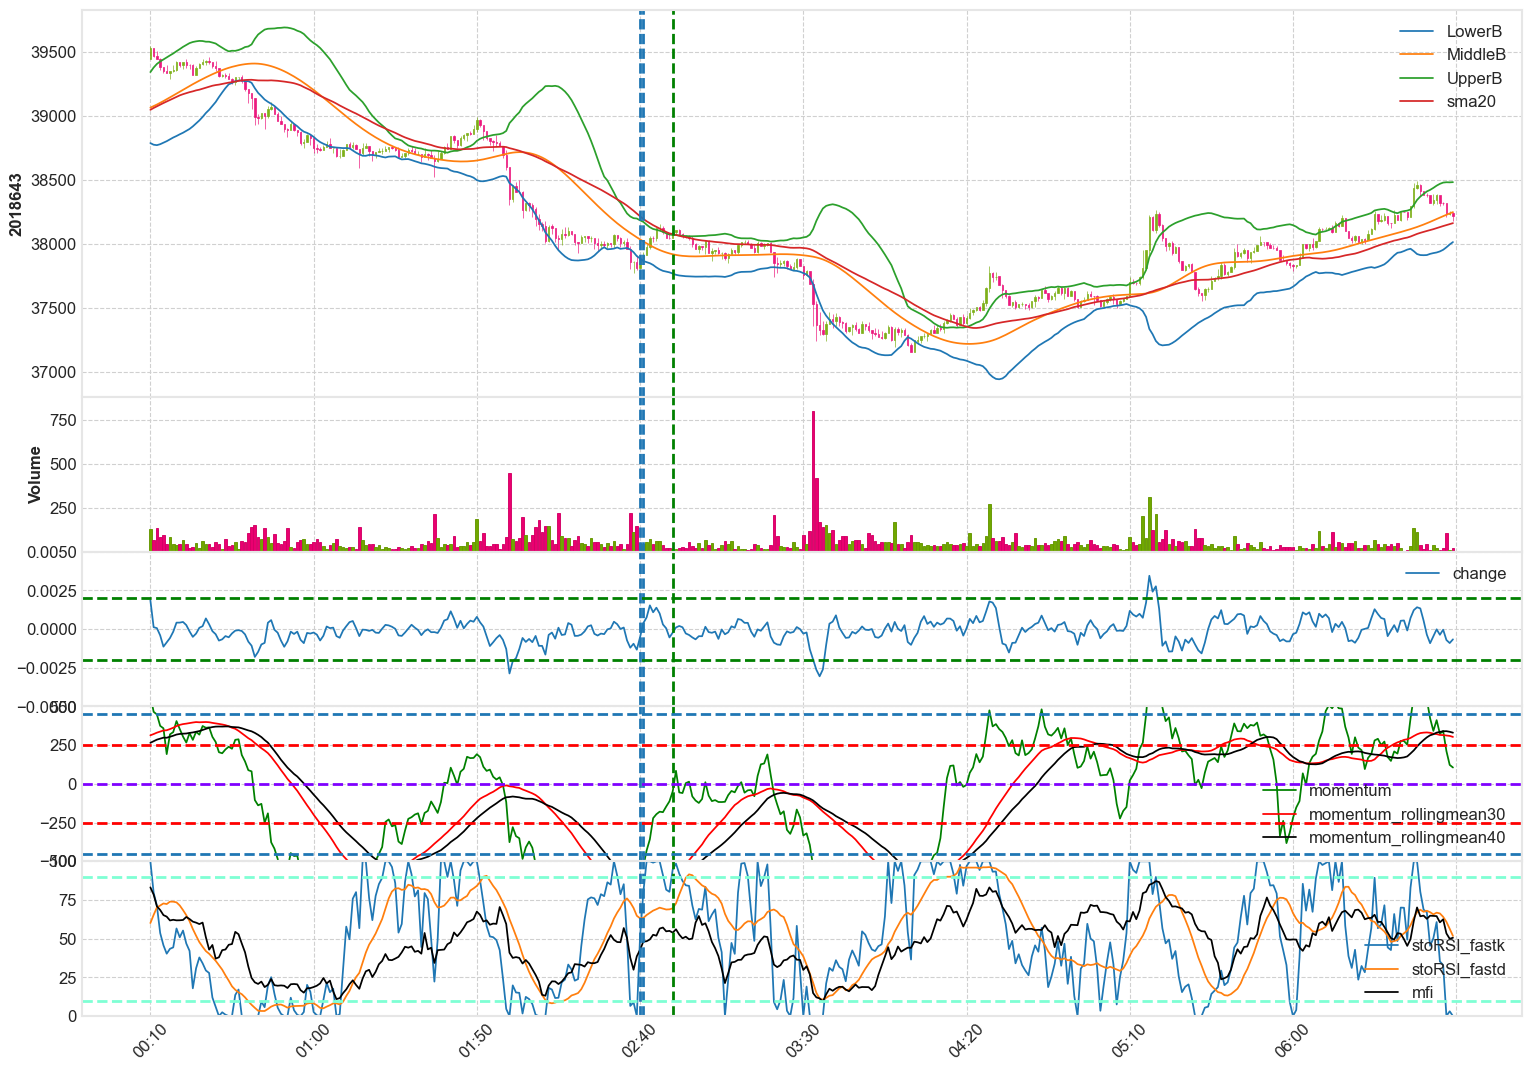

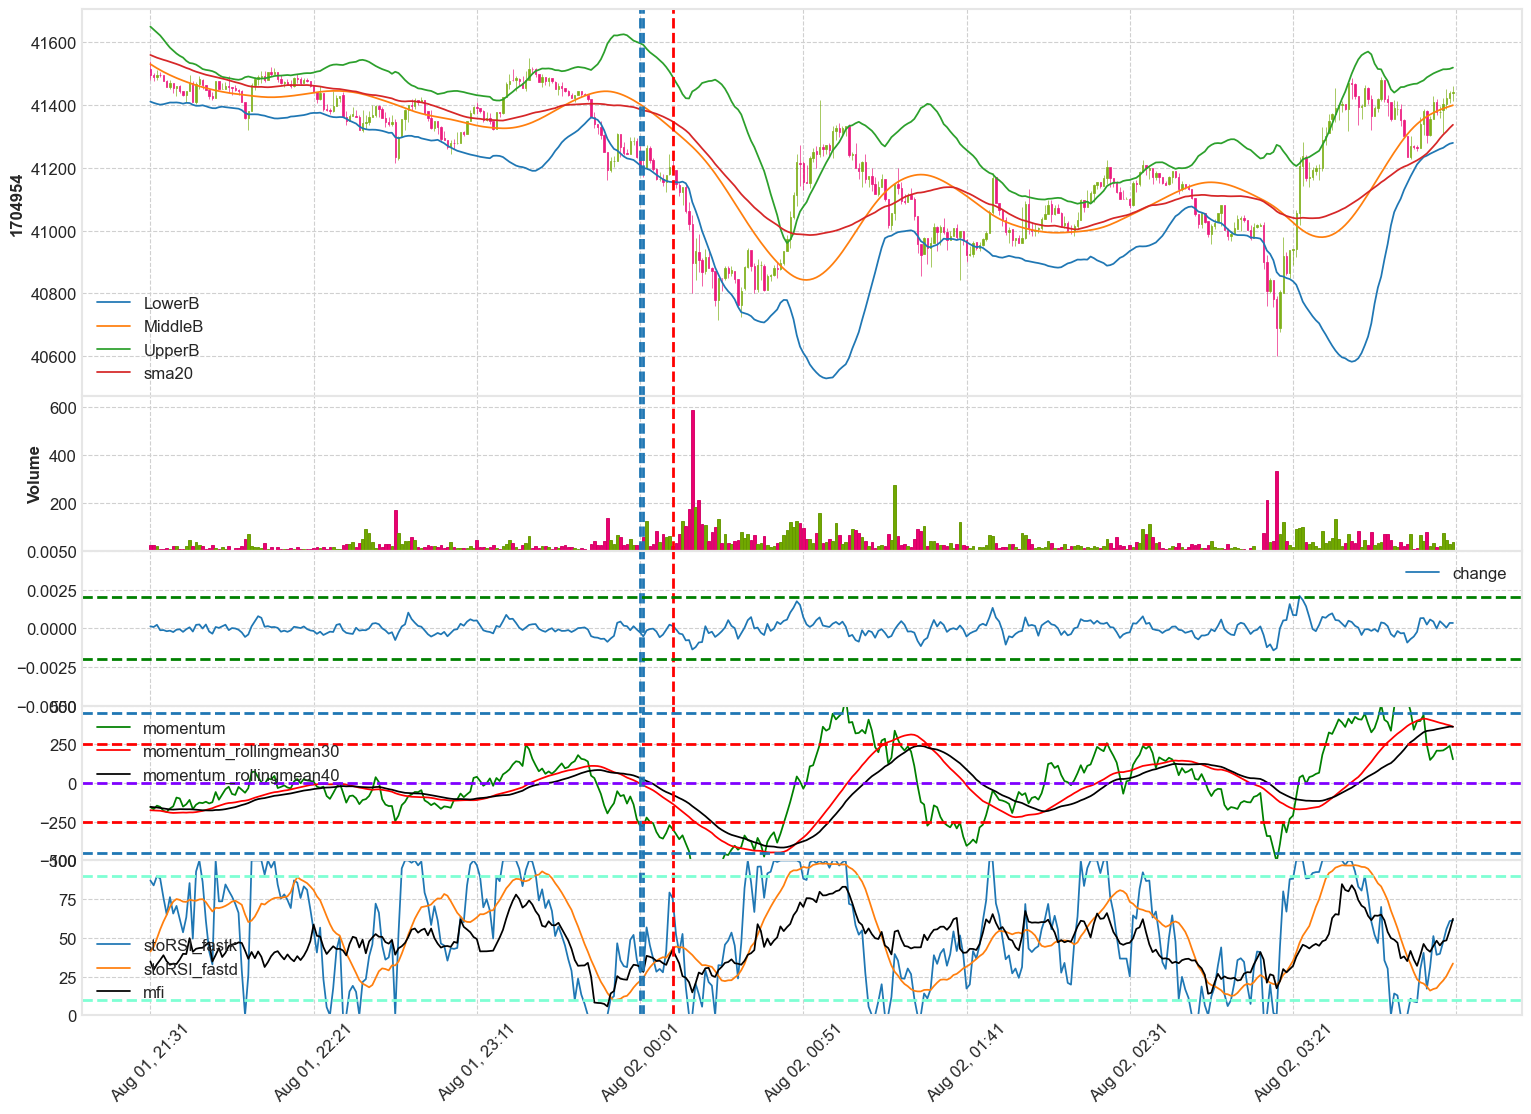

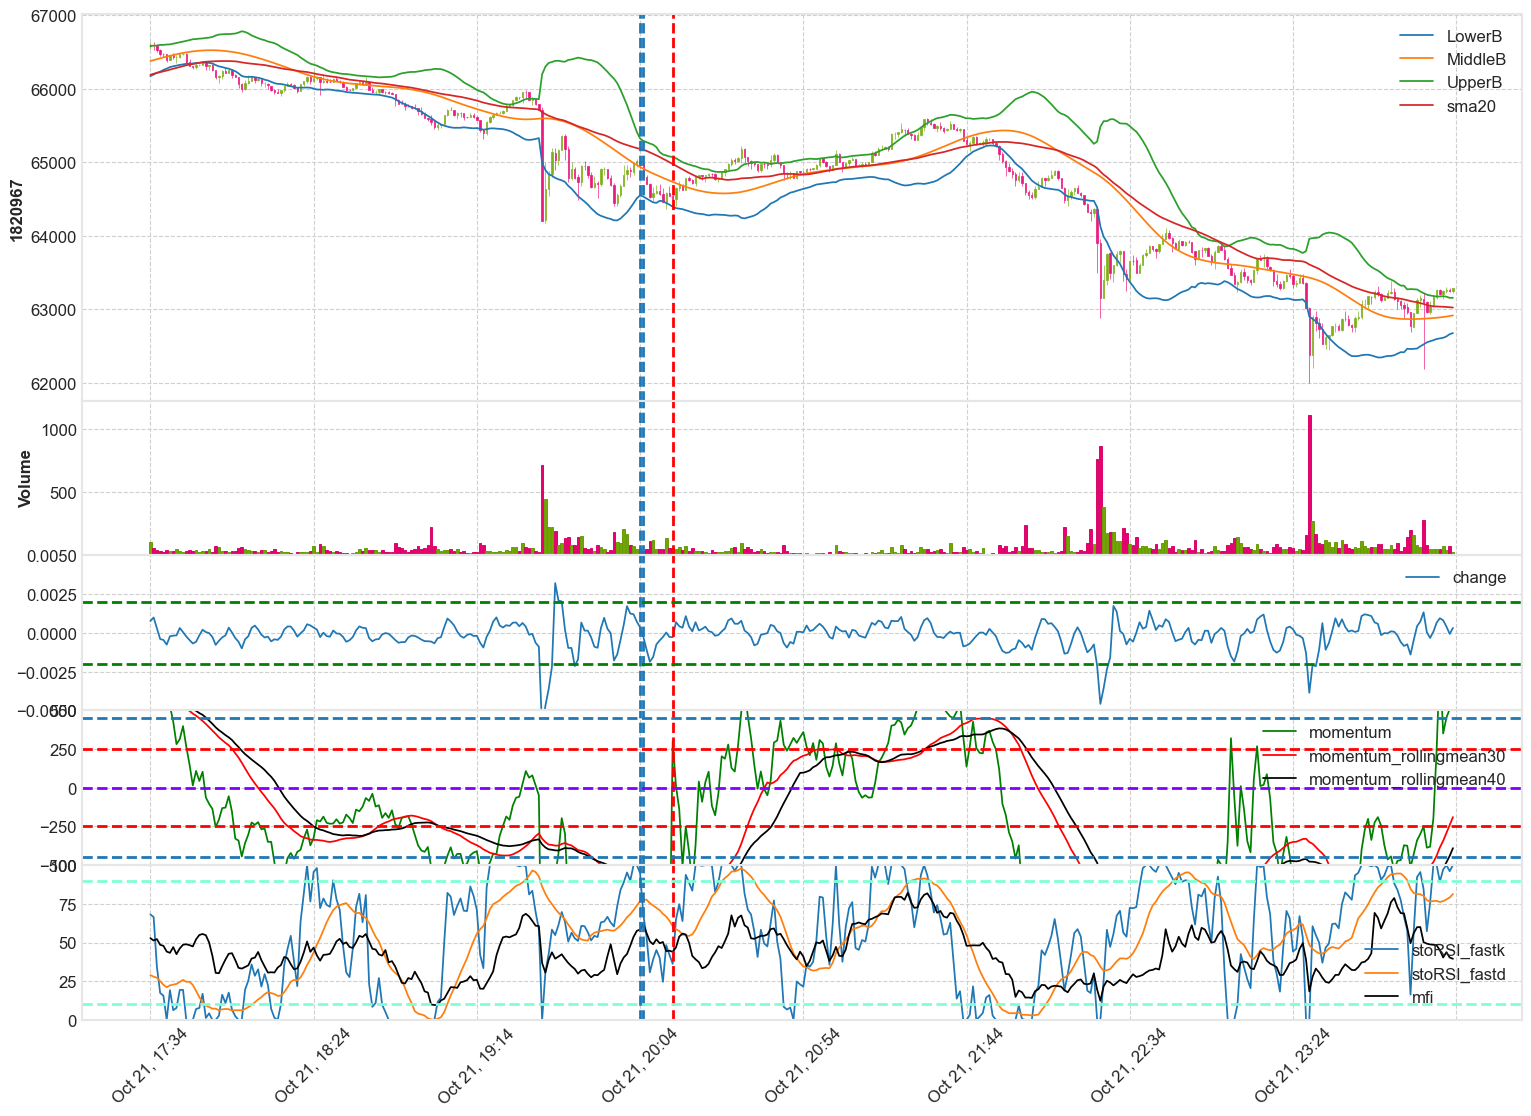

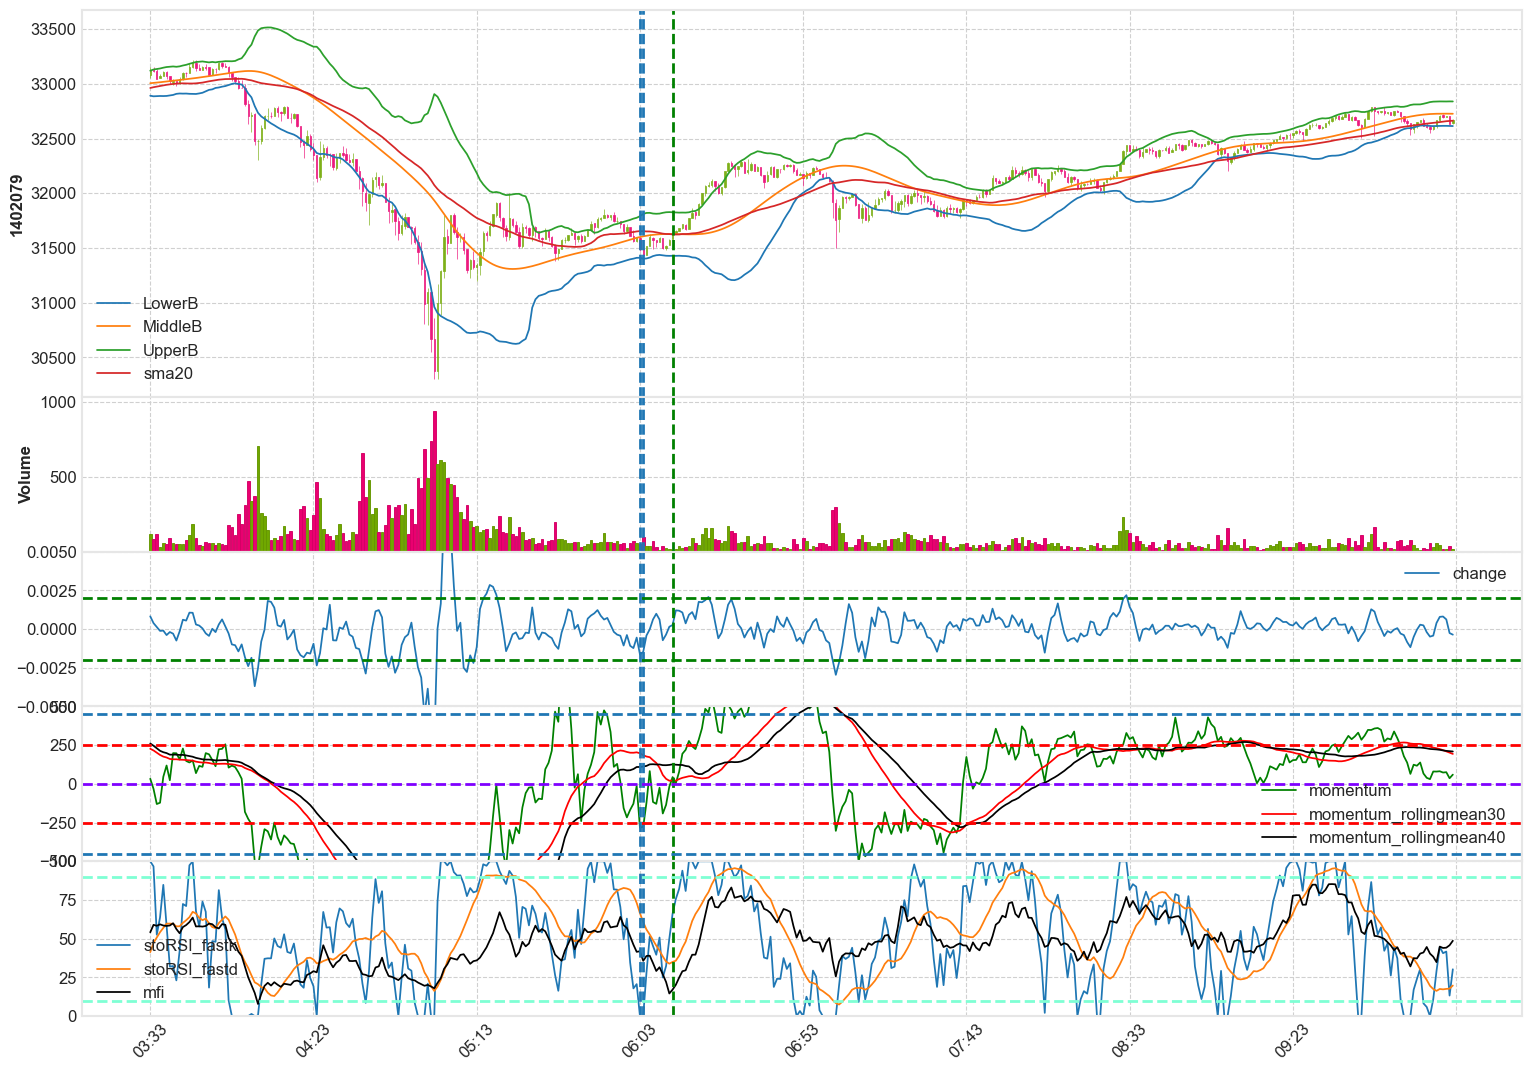

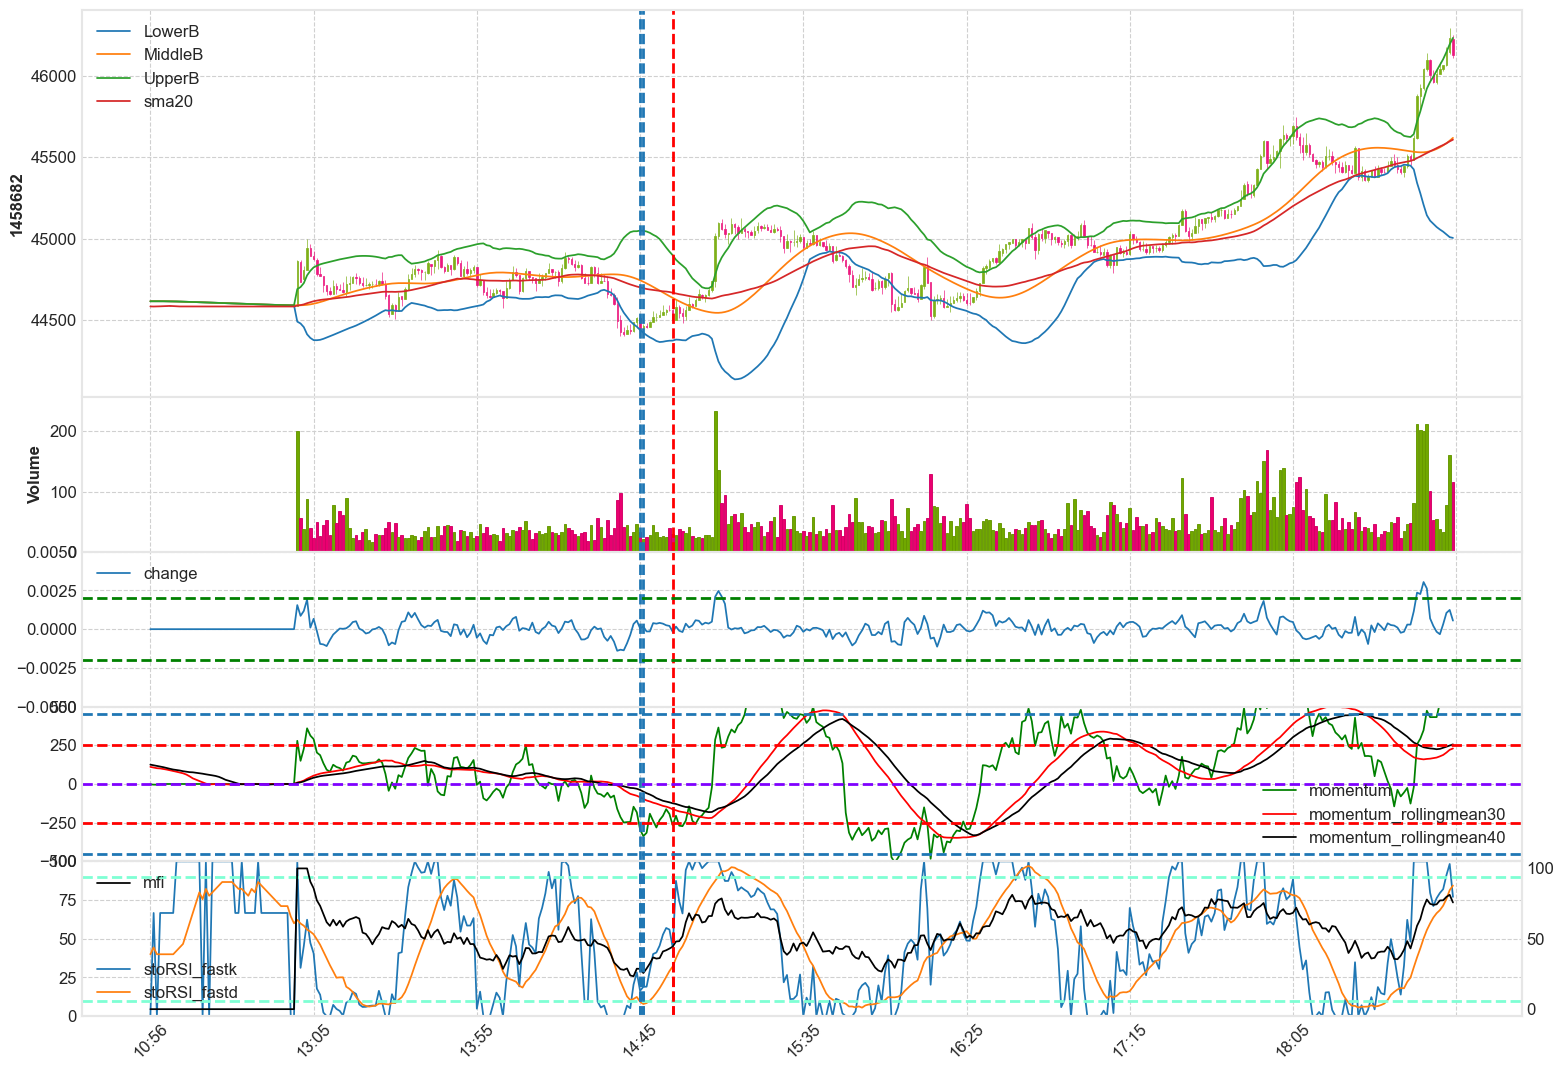

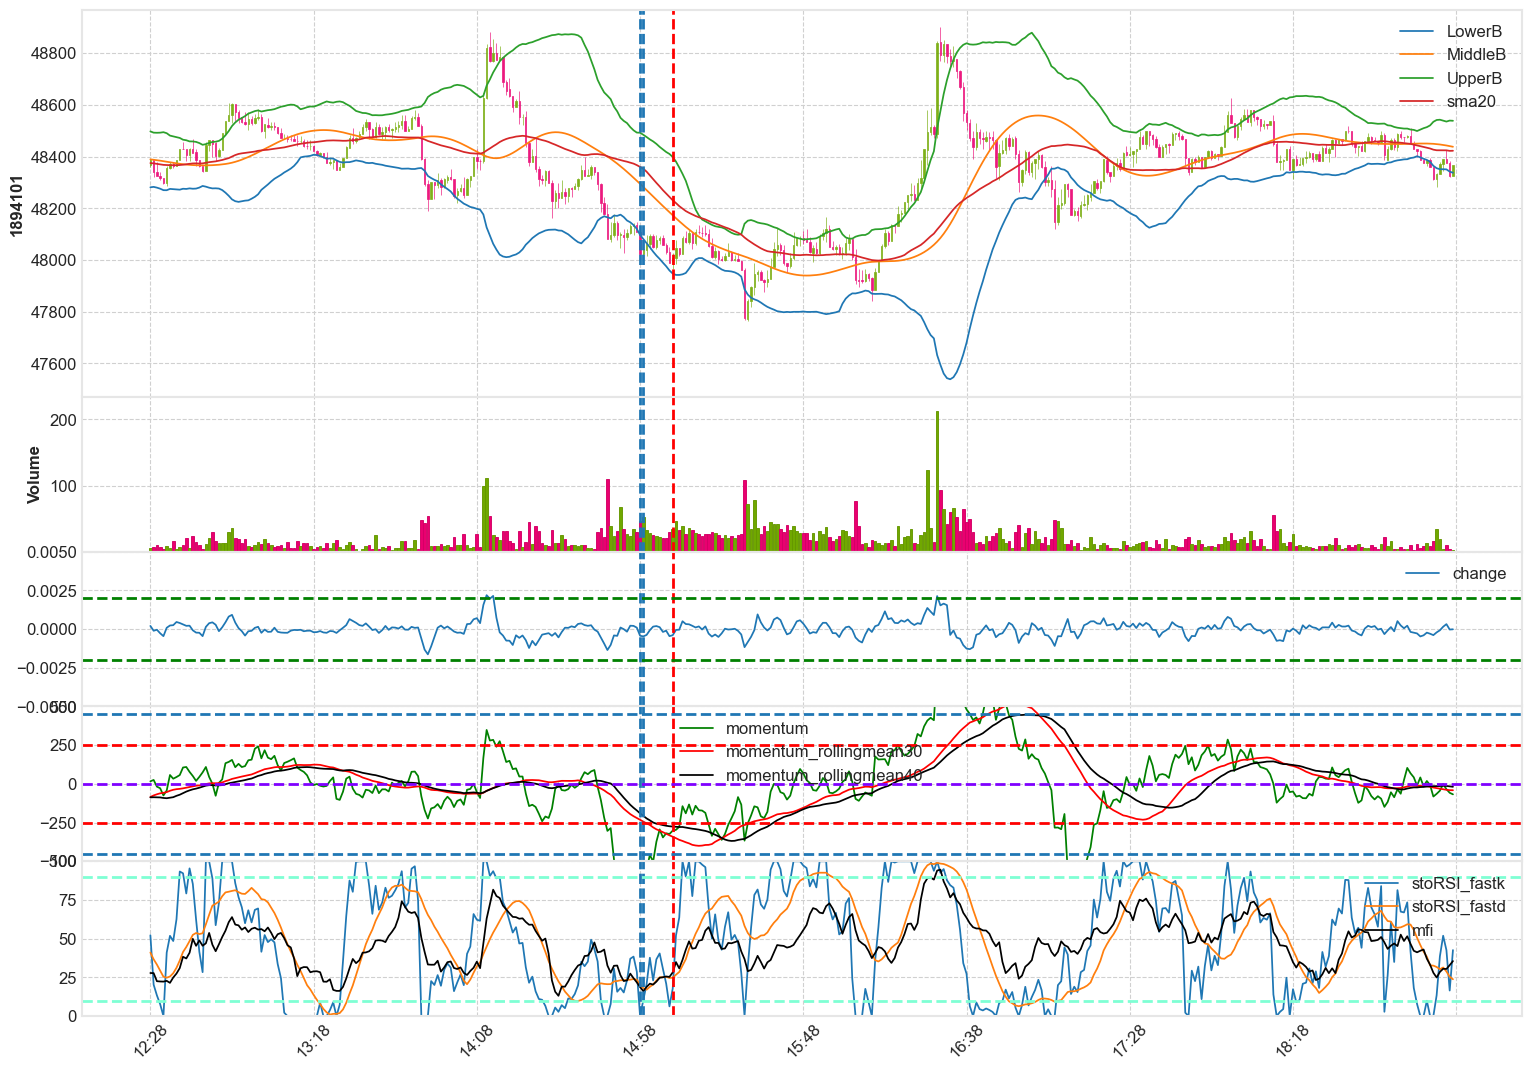

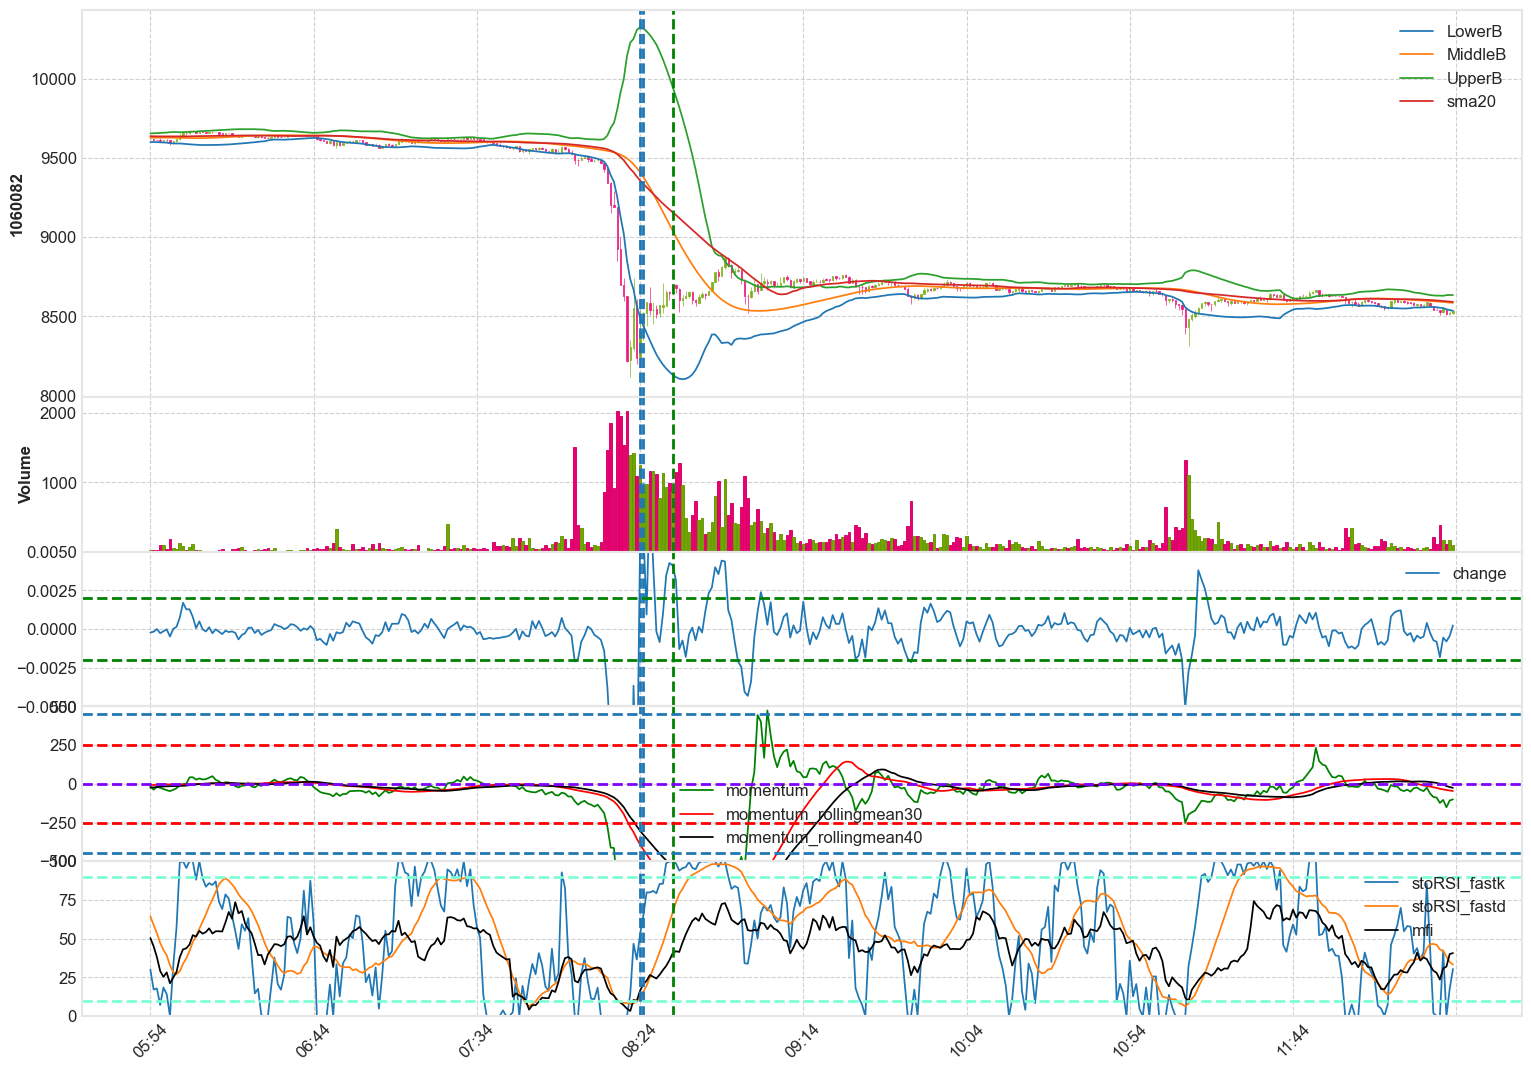

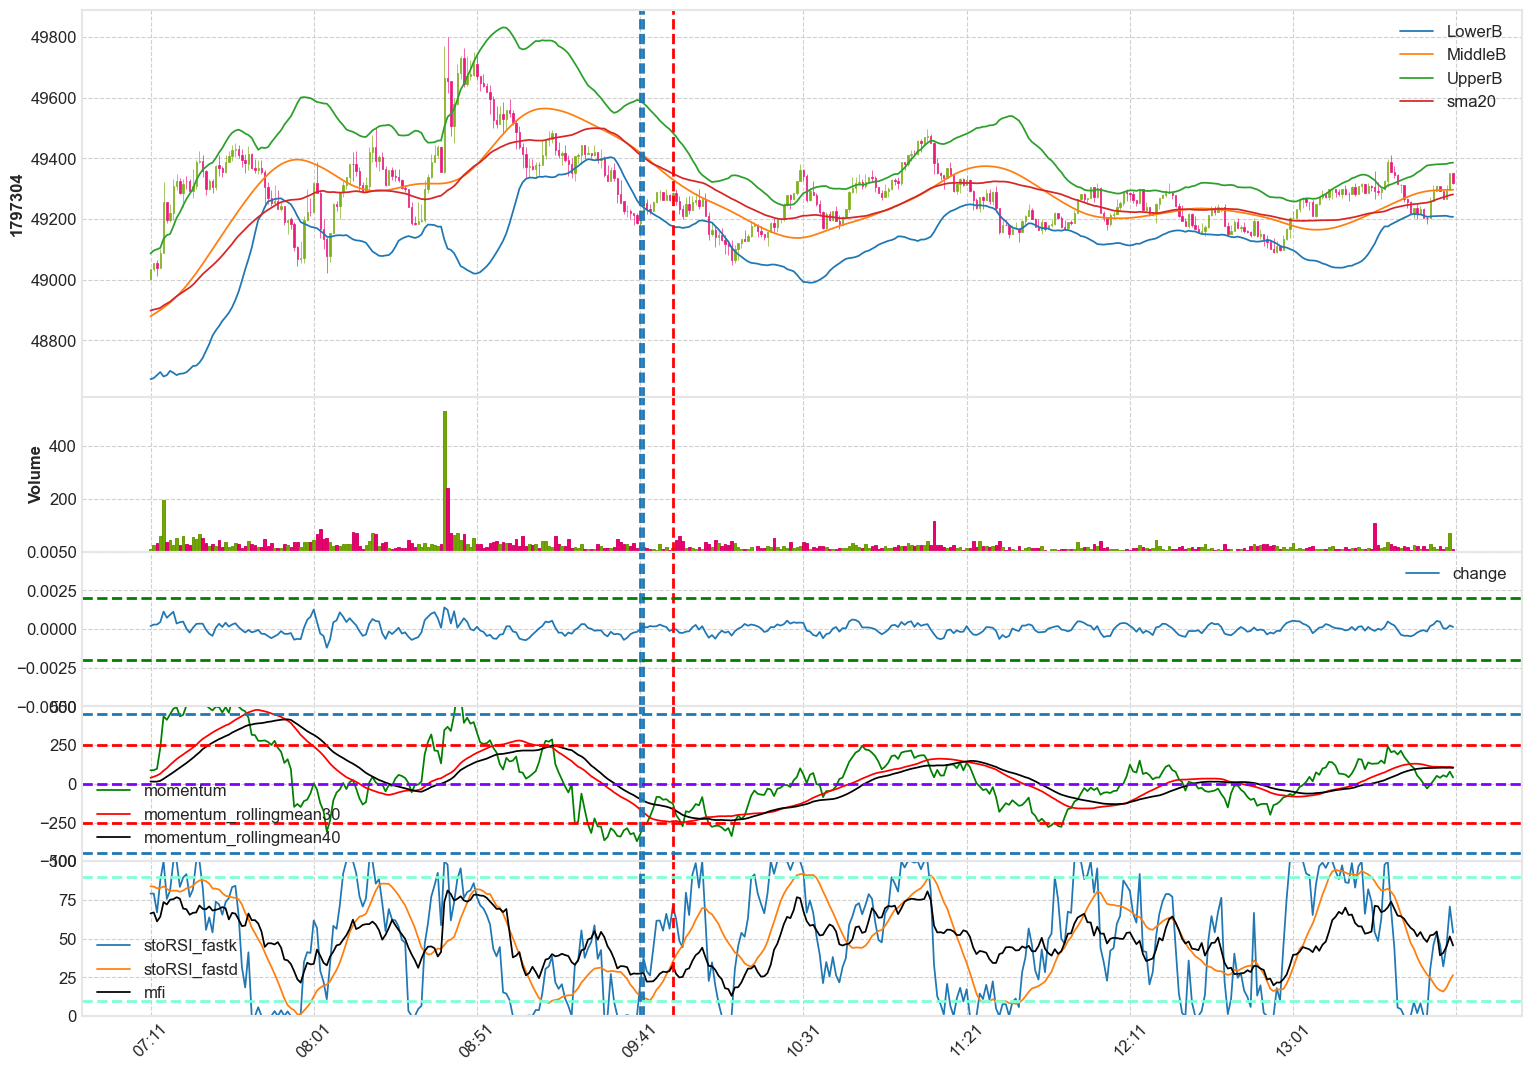

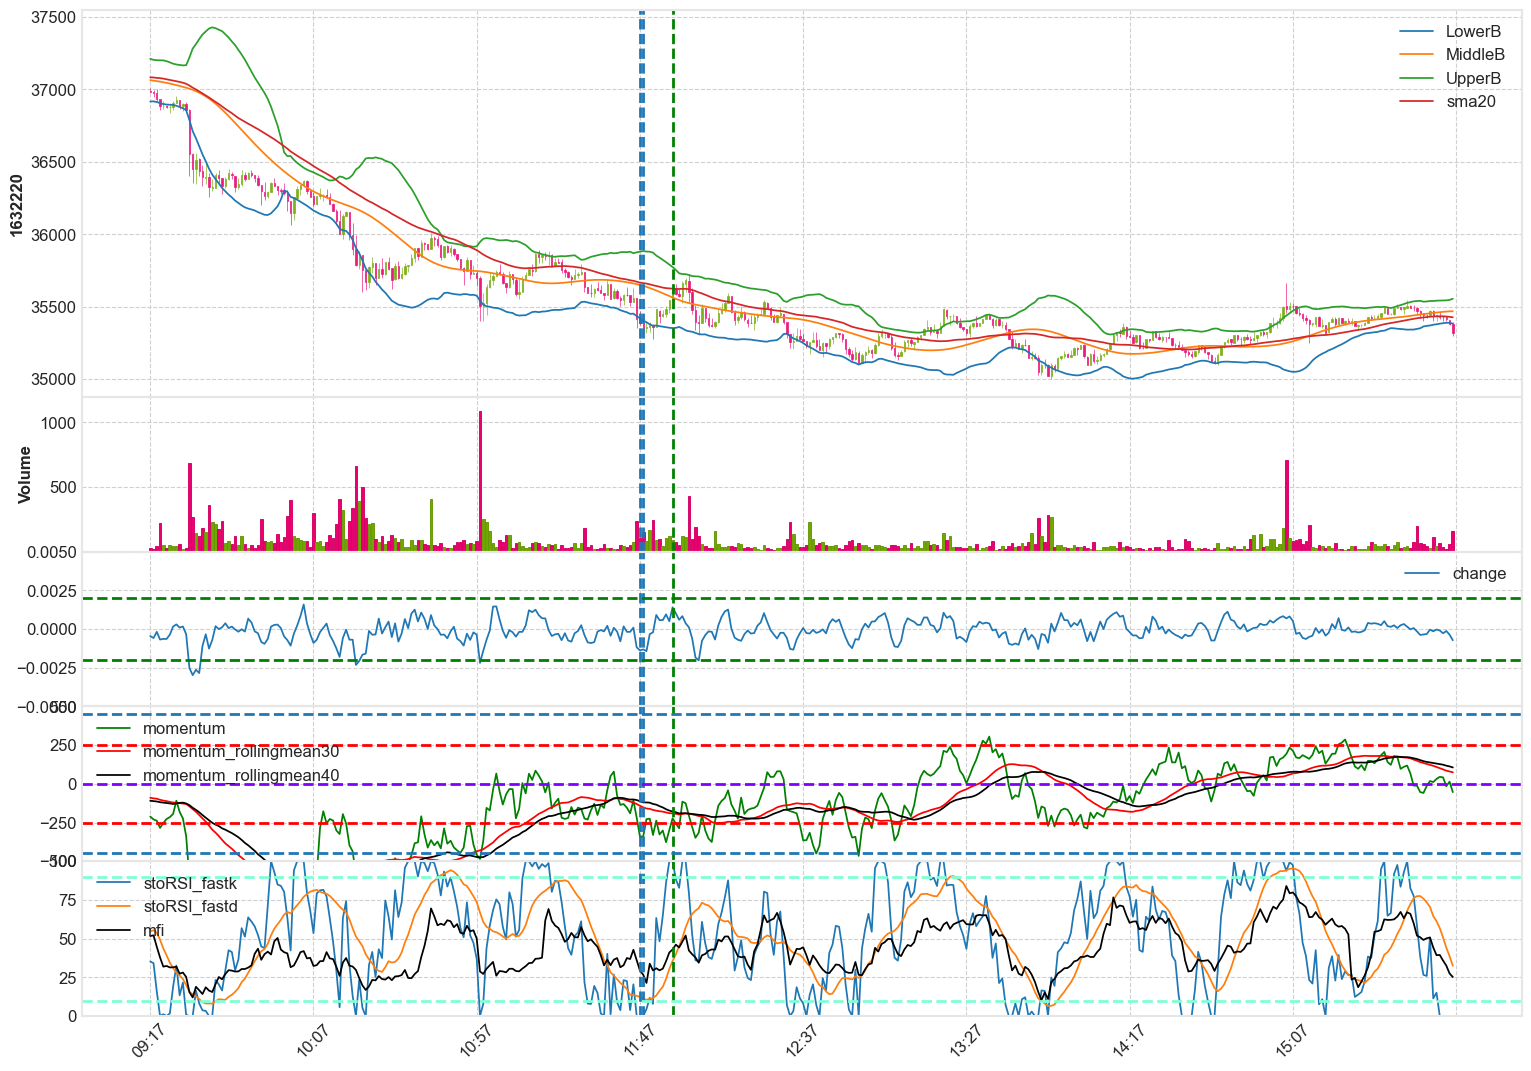

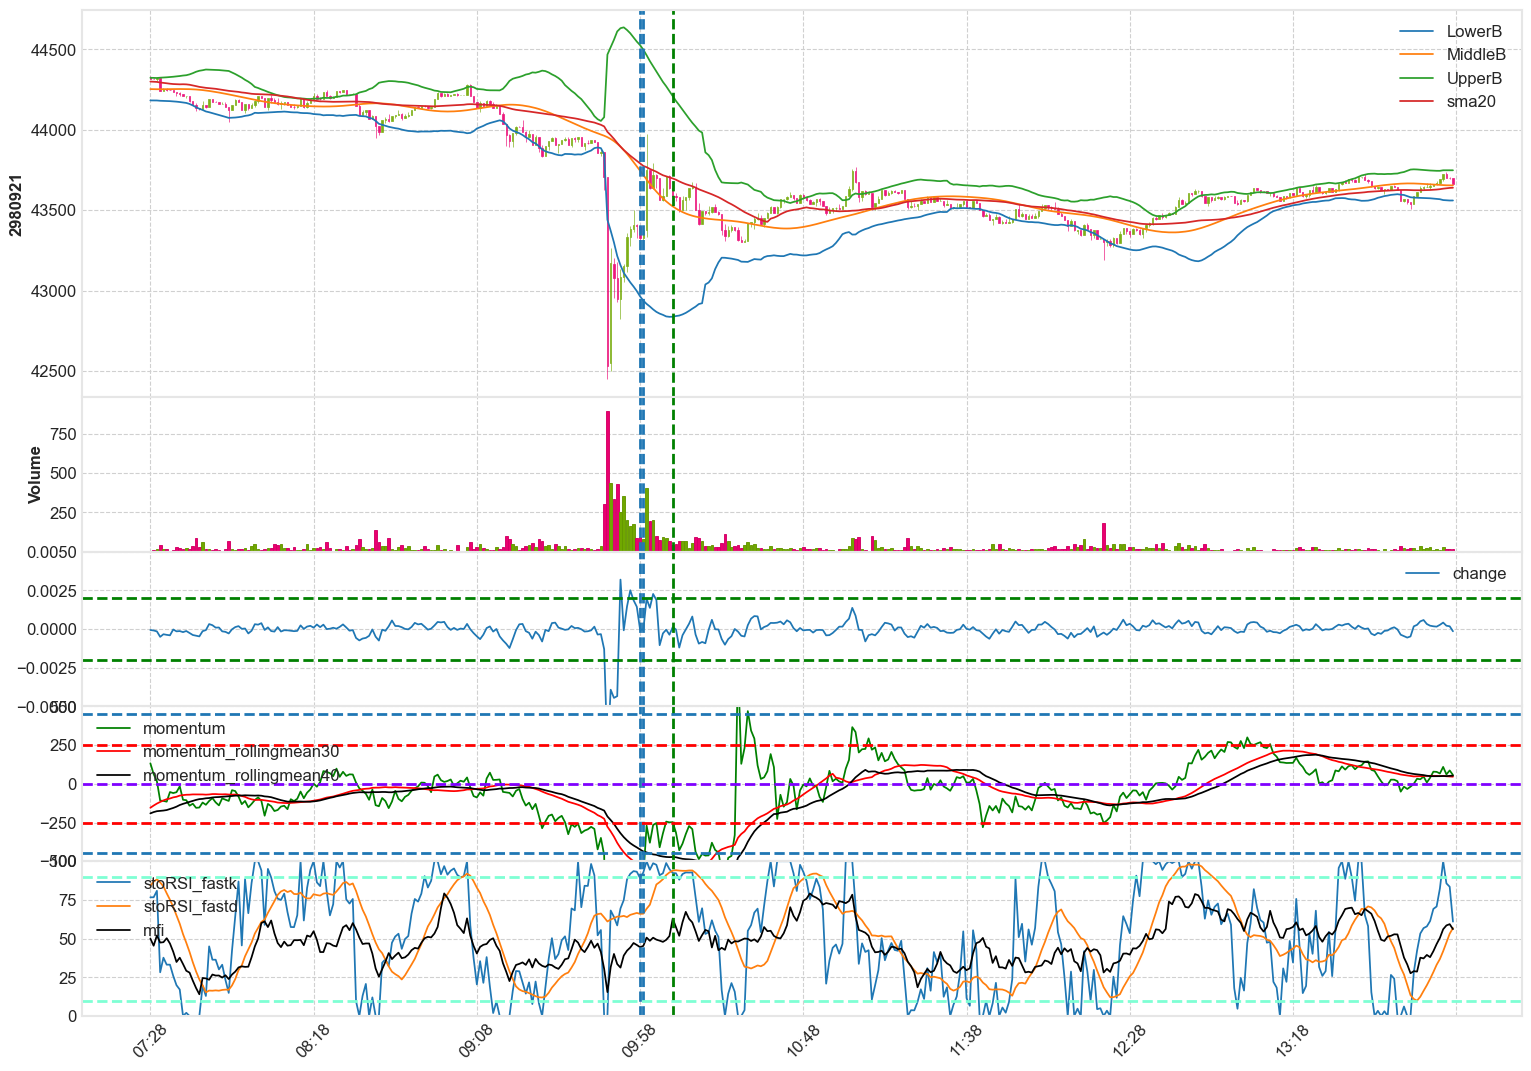

CPU times: total: 13.4 s
Wall time: 21.4 s


In [190]:
%%time
for inddex_of_frame in np.asarray(indexx)[np.where(predicted==2)[0]][:10]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    #my_vlines=[dfmpl.iloc[inddex_of_frame].name]
    #my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower30.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle30.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper30.iloc[lowerlim:upperlim],label="UpperB"),
              mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
              mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
              mpf.make_addplot(momentum.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
              mpf.make_addplot(momentum_rolling30.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean30",color="r",secondary_y=False),
              mpf.make_addplot(momentum_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean40",color="k",secondary_y=False),
              mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd"),
              mpf.make_addplot(mfi.iloc[lowerlim:upperlim],panel=4,label="mfi",color="k") 
             ]
    fig, axlist = mpf.plot(dfmpl.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2.5,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for axi,ax in enumerate(axlist):
        #for vline in my_vlines:
        ax.axvline(x=150, linestyle='--')
        ax.axvline(x=150+1, linestyle='--')
        trade_index=inddex_of_frame
        changedd= (dfmpl.Close.iloc[trade_index+10] - dfmpl.Close.iloc[trade_index+1])/dfmpl.Close.iloc[trade_index+1]
        ax.axvline(x=150+10, linestyle='--',c="g" if changedd >0.003 else "r")
        if axi==4:
            ax.axhline(-0.002, linestyle='--',c="g")
            ax.axhline(0.002, linestyle='--',c="g")
            ax.set_ylim(-0.005,0.005)
        if axi==6:
            ax.axhline(-450, linestyle='--')
            ax.axhline(450, linestyle='--')
            ax.axhline(-250, linestyle='--',c="r")
            ax.axhline(250, linestyle='--',c="r")
            ax.axhline(0,linestyle="--",c="#7F00FF",)
            ax.set_ylim(-500,500)
        if axi==8:
            ax.axhline(90, linestyle='--',c="#7FFFD4")
            ax.axhline(10, linestyle='--',c="#7FFFD4")
            ax.set_ylim(0,100)
    mpf.show()

In [26]:
#from plotting import plot_profits

In [27]:
#plot_profits(collated_data[:,2])